In [27]:
import numpy as np
import pandas as pd
import scipy.stats
import tqdm
import xswap
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model

%matplotlib inline

sns.set_style('darkgrid')
plt.style.use('dark_background')

In [2]:
df = pd.read_table('p_vs_rank.tsv')

In [3]:
r_df = (
    df
    .query('raul_edge == 0 and rwr > 0')
    .loc[:, ['rank', 'p_value', 'p_value_rank', 'lit_edge']]
)

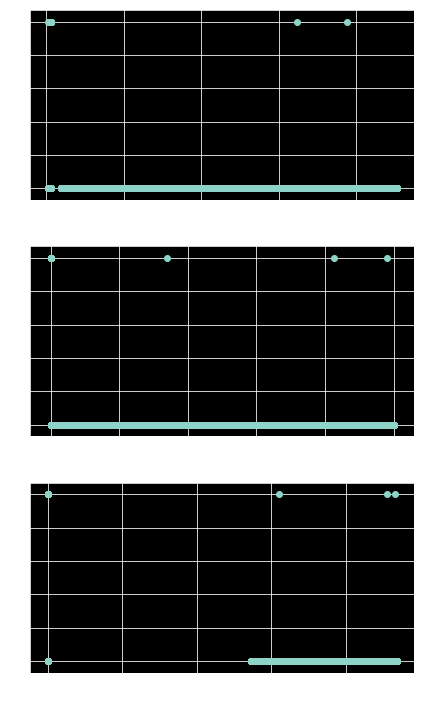

In [4]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

ax[0].scatter(x='rank', y='lit_edge', data=r_df)
ax[0].set_xlabel('rank')

ax[1].scatter(x='p_value', y='lit_edge', data=r_df)
ax[1].set_xlabel('p_value')

ax[2].scatter(x='p_value_rank', y='lit_edge', data=r_df)
ax[2].set_xlabel('p_value_rank')

plt.tight_layout()

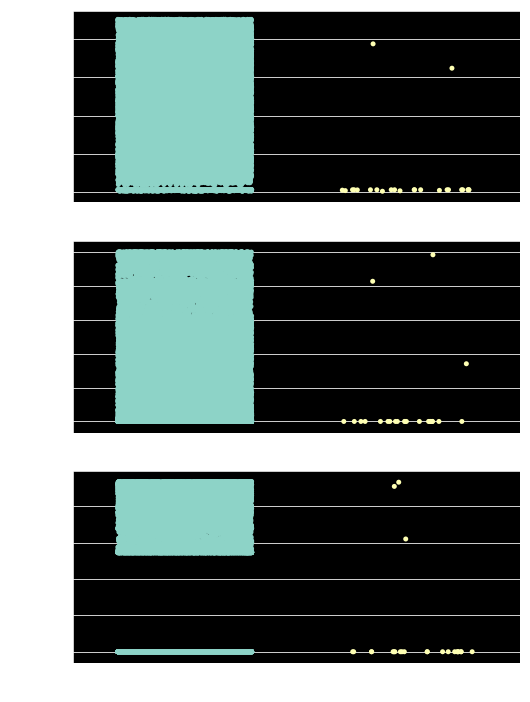

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

sns.stripplot(y='rank', x='lit_edge', data=r_df, jitter=0.3, ax=ax[0])
sns.stripplot(y='p_value', x='lit_edge', data=r_df, jitter=0.3, ax=ax[1])
sns.stripplot(y='p_value_rank', x='lit_edge', data=r_df, jitter=0.3, ax=ax[2])

Hypothesis: 

"More lit edges will be at low p-value ranks than at low value ranks"

"Using p-value rank will provide a greater enrichment... greater negative correlation?"

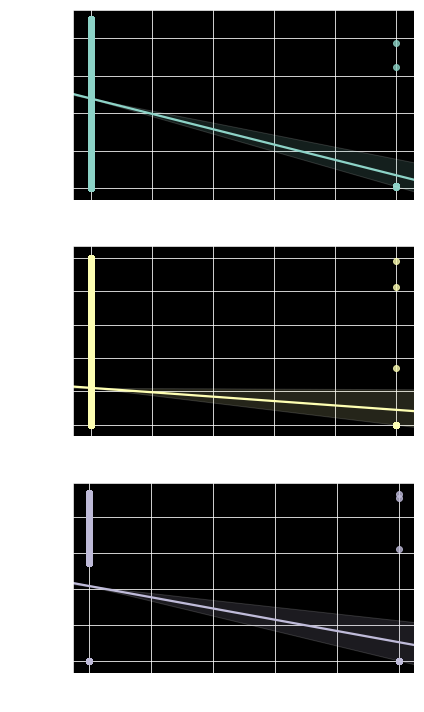

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

sns.regplot(y='rank', x='lit_edge', data=r_df, ax=ax[0])
ax[0].set_xlabel('rank')

sns.regplot(y='p_value', x='lit_edge', data=r_df, ax=ax[1])
ax[1].set_xlabel('p_value')

sns.regplot(y='p_value_rank', x='lit_edge', data=r_df, ax=ax[2])
ax[2].set_xlabel('p_value_rank')

plt.tight_layout()

In [22]:
scipy.stats.pearsonr(r_df['lit_edge'], r_df['rank'])

(-0.03882058452651705, 1.2374551653688768e-15)

In [23]:
scipy.stats.pearsonr(r_df['lit_edge'], r_df['p_value_rank'])

(-0.021634815549393272, 8.286884654092974e-06)

In [35]:
lr = sklearn.linear_model.LogisticRegression()
lr.fit(r_df['lit_edge'].values.reshape(-1, 1), r_df['rank'].values.flatten())

/home/michael/miniconda3/envs/xswap-analysis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/michael/miniconda3/envs/xswap-analysis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


KeyboardInterrupt: 

In [ ]:
lr.score(r_df['lit_edge'].values.reshape(-1, 1), r_df['rank'].values.flatten())

In [25]:
(
    r_df
    .query('lit_edge == 1 and p_value_rank < 100')
)

,rank,p_value,p_value_rank,lit_edge
174648,568.0,0.0,1.0,1
196096,568.0,0.0,1.0,1
303336,414.0,0.0,1.0,1
415172,568.0,0.0,1.0,1
422832,568.0,0.0,1.0,1
462664,568.0,0.0,1.0,1
482580,349.0,0.0,1.0,1
516284,568.0,0.0,1.0,1
571436,568.0,0.0,1.0,1
727700,568.0,0.0,1.0,1
